# Livrable 2 : Auto-Encodeur

#### Date : 18/10/2023

#### Auteurs :
- Colin Hamerel
- Louis Brasseur
- Sofiane Benazouzi
- Kevin Friedrich

## Sommaire : 

1. Auto-encodeur
    * Définition & cas d'utilisation
    * Attentes du projet
1. Application dans notre cas
    * Description du processus & Mise en application
    * Maintenance
1. Résultats 
1. Conclusion

## Auto-encodeur
#### Définition & cas d’utilisation
Un auto-encodeur est un type de réseau de neurones artificiels utilisé en apprentissage automatique et en intelligence artificielle. Il fait partie de la famille des réseaux de neurones dits "non supervisés" car il n'a pas besoin d'étiquettes de sortie pour apprendre à partir des données. Son objectif principal est de compresser et de représenter efficacement les données en entrée, puis de les reconstruire avec une précision aussi proche que possible de l'original. Les auto-encodeurs sont composés de deux parties principales : l'encodeur et le décodeur. 
Un auto-encodeur est un outil puissant pour la compression des données et peut être utilisé pour débruiter des données en apprenant à représenter les données d'origine de manière compacte et en utilisant cette représentation pour restaurer les données bruitées. C'est un exemple d'application utile de l'apprentissage non supervisé en intelligence artificielle.

#### Auto-encodeur variationnelle (VAE)
Un autoencodeur variationnel (VAE) est une variante d'auto-encodeur classique. C'est un modèle de réseau de neurones capable de générer de nouvelles données en échantillonnant à partir d'un espace latent. Il étend l'autoencodeur traditionnel en utilisant des concepts de probabilité pour représenter la variabilité des données. Les VAE sont couramment utilisés pour la génération d'images et d'autres tâches de génération de données.

#### Attentes du projet
L’objectif de ce livrable est d’ajouter une étape de nettoyage supplémentaire des données, en effet durant le passage en pipeline certaines de nos images seront probablement bruitées et donc détériorées. 
On va utiliser nos images propres et les bruiter pour entrainer notre auto-encodeur au débruitage.
Comme expliqué précédemment l’application de ce livrable se composera de plusieurs parties : Données d’entrée, Encodeur, Espace latent, Décodeur et finalement Données de sortie.

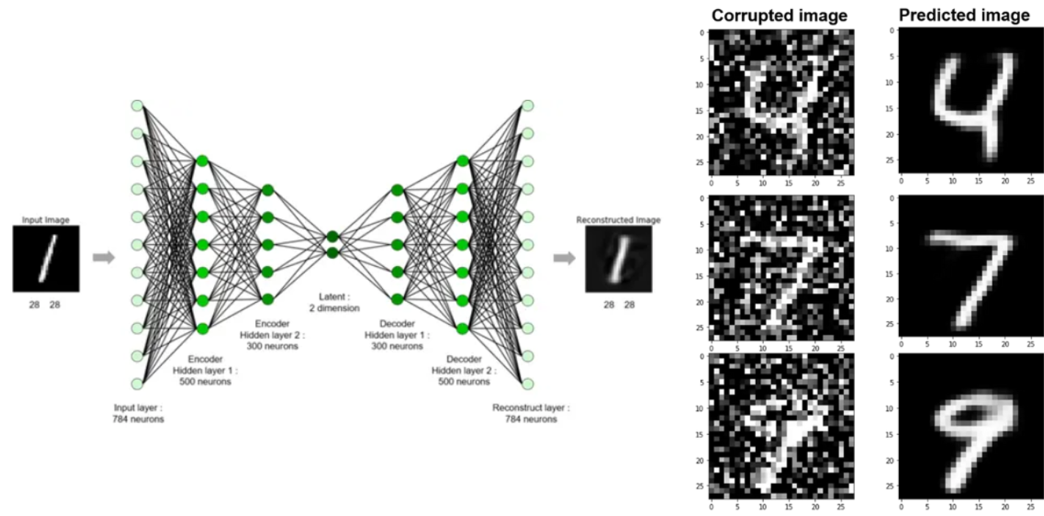



## Application dans notre cas

### Pré-traitrement pour bon fonctionnement du notebook (important)

Afin de bien faire fonctionner le notebook il est impératif de respecter les choses suivantes : 

- Nommage des dossiers sources et des dossiers modèles/scripts : 
Il est impératif de modifier au pré-alable le contenu du fichier .env afin de faire pointer les bonnes variables de paths au bon endroits

- Création des dossiers de poids afin de garantir la sauvegarde des poids (étape après l'entrainement) il faut impérativement créer le dossier avant de sauvegarder le fichier

#### Description du processus & mise en application

Dans notre cas, un dataset de données "noisy" nous a été fourni et comme énoncé précédement, nous devons donc augmenter la qualité de l'image.

Nous allons dans un premier temps charger nos librairies et déclarer nos variables : 

In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import sys
import matplotlib.pyplot as plt
from tensorflow import keras
from keras_cv.layers import RandomGaussianBlur
from random import randint, seed

tf.keras.backend.clear_session()

# Configurations principales de nos modèles
IMG_SIZE          = 224             # taille coté final d'une image en pixel (ici 224x224)
NB_EPOCHS_DENOISE = 3               # nombre epoch alogithme debruiter
BATCH_SIZE        = 8            # taille batch de traitement
SAVE_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image

# Import du .env
import dotenv
import os

# Chargement du .env !!!!!!!!!!!! CHANGER LE PATH !!!!!!!!!!!!!!
# Renvoie true si le .env est chargé
dotenv.load_dotenv('/tf/science-de-la-donnee/.env.local')

# Import des variables d'environnement
models_path = os.environ.get('MODELS_PATH_LIVRABLE2')
script_path = os.environ.get('SCRIPT_PATH_LIVRABLE2')
WEIGHT_PATH_LIVRABLE2 = os.environ.get('WEIGHT_PATH_LIVRABLE2')
SOURCE_LIVRABLE2_PATH = os.getenv("SOURCE_LIVRABLE2_PATH")

# Ajout des paths au sys.path
sys.path.insert(0, models_path)
sys.path.insert(0, script_path)

# Import des modèles
import homemade
import test2
import resnet

# Import des scripts
import processImage
import displayImage
import displayMetrics
import computeMetrics

On sépare notre jeu de données en 2 jeux différents

In [ ]:
# Définition du train et test set
x_train, x_test = image_dataset_from_directory(
    SOURCE_LIVRABLE2_PATH,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    # label_mode=None,
    shuffle=False,
    validation_split=0.2,
    subset="both",
    seed=123,
    color_mode="rgb"
)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# On map les images pour les normaliser
x_train = x_train.map(lambda x,y: (x/255,y))
x_test = x_test.map(lambda x,y: (x/255,y))

On redéfini maintenant nos jeux de données en ajoutant différentes perturbations. L'intêret de celles-ci est de permettre à notre modèle d'apprendre du bruit et de par la suite, être capable de l'enlever. Afin d'avoir un modèle robuste, c'est à dire un modèle qui sait s'adapter aux différents bruits, nous allons donc ajouter différents type de bruits à notre dataset. Donc pour chacune de nos images, nous ajoutons la même avec flou, du bruit, du flou et du bruit ainsi que l'image propre elle même. Ceci permettra à notre modèle d'être polyvalent !

Les valeurs de perturbations ont été choisi de différentes manières. 
La 1ère est que l'on a analysé les images bruitées données pour le livrable 2, et celles-ci se trouvent être peu perturbées donc nous avons choisi une faible valeur de bruit. 
Quant au flou, nous avons remarqué que dans nos résultats initiaux, les images nettoyées étaient toutes très flous. Afin de pallier à ce soucis, nous avons donc choisi une valeur moyenne.

In [ ]:
from keras_cv.layers import RandomGaussianBlur

def add_noise(img, perturbation_conf):
    pertubation = perturbation_conf['perturbation']
    noised_img = img
    if pertubation == 1:
        blur_kernel_value = perturbation_conf['blur_kernel_size']
        noised_img = RandomGaussianBlur(kernel_size=blur_kernel_value, factor=(0.5, 3))(noised_img)
    elif pertubation == 2:
        noise_value = perturbation_conf['noise_factor']
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_value/255, dtype=tf.float32)
        noised_img = tf.cast(img, tf.float32) + noise
    elif pertubation == 3:
        noise_value = perturbation_conf['noise_factor']
        blur_kernel_value = perturbation_conf['blur_kernel_size']
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_value/255, dtype=tf.float32)
        noised_img = tf.cast(img, tf.float32) + noise
        noised_img = RandomGaussianBlur(kernel_size=blur_kernel_value, factor=(0.5, 1))(noised_img)
    else:
        noised_img = img
        
    return noised_img, img


noise_configuration = {
    0:{
    'perturbation': 1,
    'blur_kernel_size': 6,
    },
    1:{
    'perturbation': 2,
    'noise_factor': 20
    },
    2:{
    'perturbation': 3,
    'noise_factor': 12,
    'blur_kernel_size': 2
    },
    3:{
    'perturbation': 0
    }
}

x_train_noisy = x_train.map(lambda x,y: (add_noise(x, noise_configuration[1])))
x_test_noisy = x_test.map(lambda x,y: (add_noise(x, noise_configuration[1])))

x_train_blur = x_train.map(lambda x,y: (add_noise(x, noise_configuration[0])))
x_test_blur = x_test.map(lambda x,y: (add_noise(x, noise_configuration[0])))

x_train_noise_blur = x_train.map(lambda x,y: (add_noise(x, noise_configuration[2])))
x_test_noise_blur = x_test.map(lambda x,y: (add_noise(x, noise_configuration[2])))

x_train_clean = x_train.map(lambda x,y: (add_noise(x, noise_configuration[3])))
x_test_clean = x_test.map(lambda x,y: (add_noise(x, noise_configuration[3])))

random_train_set = x_train_clean.concatenate(x_train_noisy).concatenate(x_train_blur).concatenate(x_train_noise_blur)
random_test_set = x_test_clean.concatenate(x_test_noisy).concatenate(x_test_blur).concatenate(x_test_noise_blur)

On peut ensuite visualiser l'image "originelle" ainsi que l'image **bruitée**

In [ ]:
displayImage.display_images(list(x_train.take(1).as_numpy_iterator())[0][0], n=1)
displayImage.display_images(list(x_train_blur.take(1).as_numpy_iterator())[0][0], n=1)
displayImage.display_images(list(x_train_noisy.take(1).as_numpy_iterator())[0][0], n=1)
displayImage.display_images(list(x_train_noise_blur.take(1).as_numpy_iterator())[0][0], n=1)
displayImage.display_images(list(x_train_clean.take(1).as_numpy_iterator())[0][0], n=1)

Attaquons à présent l'autoencoder en lui même

Nous allons ici choisir le type d'autoencoder pour la suite du processus

In [ ]:
MODEL_CHOSEN = "autoencoder_pooling"

def load_model(model_choosen):
    match(model_choosen):
        case 'autoencoder_pooling':
            model = homemade.build(IMG_SIZE)
        case 'autoencoder_no_pooling':
            model = test2.build(IMG_SIZE)
        case 'resnet':
            model = resnet.build(IMG_SIZE)
    return model
autoencoder = load_model(MODEL_CHOSEN)
autoencoder.summary()

Ensuite on entraine notre modèle d'autoencodeur

In [ ]:
history = autoencoder.fit(
    random_train_set,
    epochs=NB_EPOCHS_DENOISE,
    shuffle=True,
    validation_data=random_train_set
)

On enregistre les poids de notre modèle

In [ ]:
model_weight_path = WEIGHT_PATH_LIVRABLE2 + MODEL_CHOSEN + '/weights.h5' 
autoencoder.save_weights(model_weight_path)

On peut aussi charger des poids même si cette étape est facultative

In [ ]:
autoencoder.load_weights(WEIGHT_PATH_LIVRABLE2 + MODEL_CHOSEN + '/weights.h5')

Une fois le modèle entrainé ou bien chargé, nous pouvons procéder au test de celui-ci. Pour se faire, nous allons calculer l'accuracy et la loss pour chaque perturbation afin d'avoir une idée plus précise des points forts et points de notre modèle et surtout de voir s'il est robuste. 

In [ ]:
test_sets = {
        'noisy': x_test_noisy,
        'blur': x_test_blur,
        'noise_blur': x_test_noise_blur,
        'clean': x_test_clean,
}

accuracy, loss = computeMetrics.compute(autoencoder, test_sets)

displayMetrics.display(accuracy, loss)

On affiche ensuite notre image bruitée et celle débruitée grâce à notre modèle.

In [ ]:
for img_index in range(3,6):
    original = list(x_test_clean.take(1).as_numpy_iterator())[0][0][img_index]
    noisy = list(x_test_noisy.take(1).as_numpy_iterator())[0][0][img_index]
    denoised = autoencoder.predict(list(x_test_clean.take(1).as_numpy_iterator())[0][0])[img_index]

    displayImage.display_images_single_row(original, noisy, denoised)

#### Maintenance

Afin de bien maintenir ce notebook et permettre une maintenance facile ainsi qu'une manipulation simple nous avons décidé d'avoir un système de "séléction" du modèle avant de procéder au traîtement, cela nous a permis de lancer et comparer tous nos modèles sans besoin de modifications lourdes. En plus de cela l'organisation actuelle est assez proche d'une partie de la pipeline que nous devrons fournir pour la fin du projet, on pourra ainsi fusioner nos étapes en regroupant à l'initialisation le choix des modèles et autres paramètres initiaux.

## Résultats

#### Autoencodeur convolutif avec réduction de dimensions

Nous avons dans un premier temps pris un modèle réalisé à partir du workshop sur l'autoencodeur et que nous avons adapté à des images plus grande et plus complexe. Pour ce faire, nous avons donc exécuté la pipeline et voici les résultats obtenus :

Image bruitée / Image débruitée :

Flou: 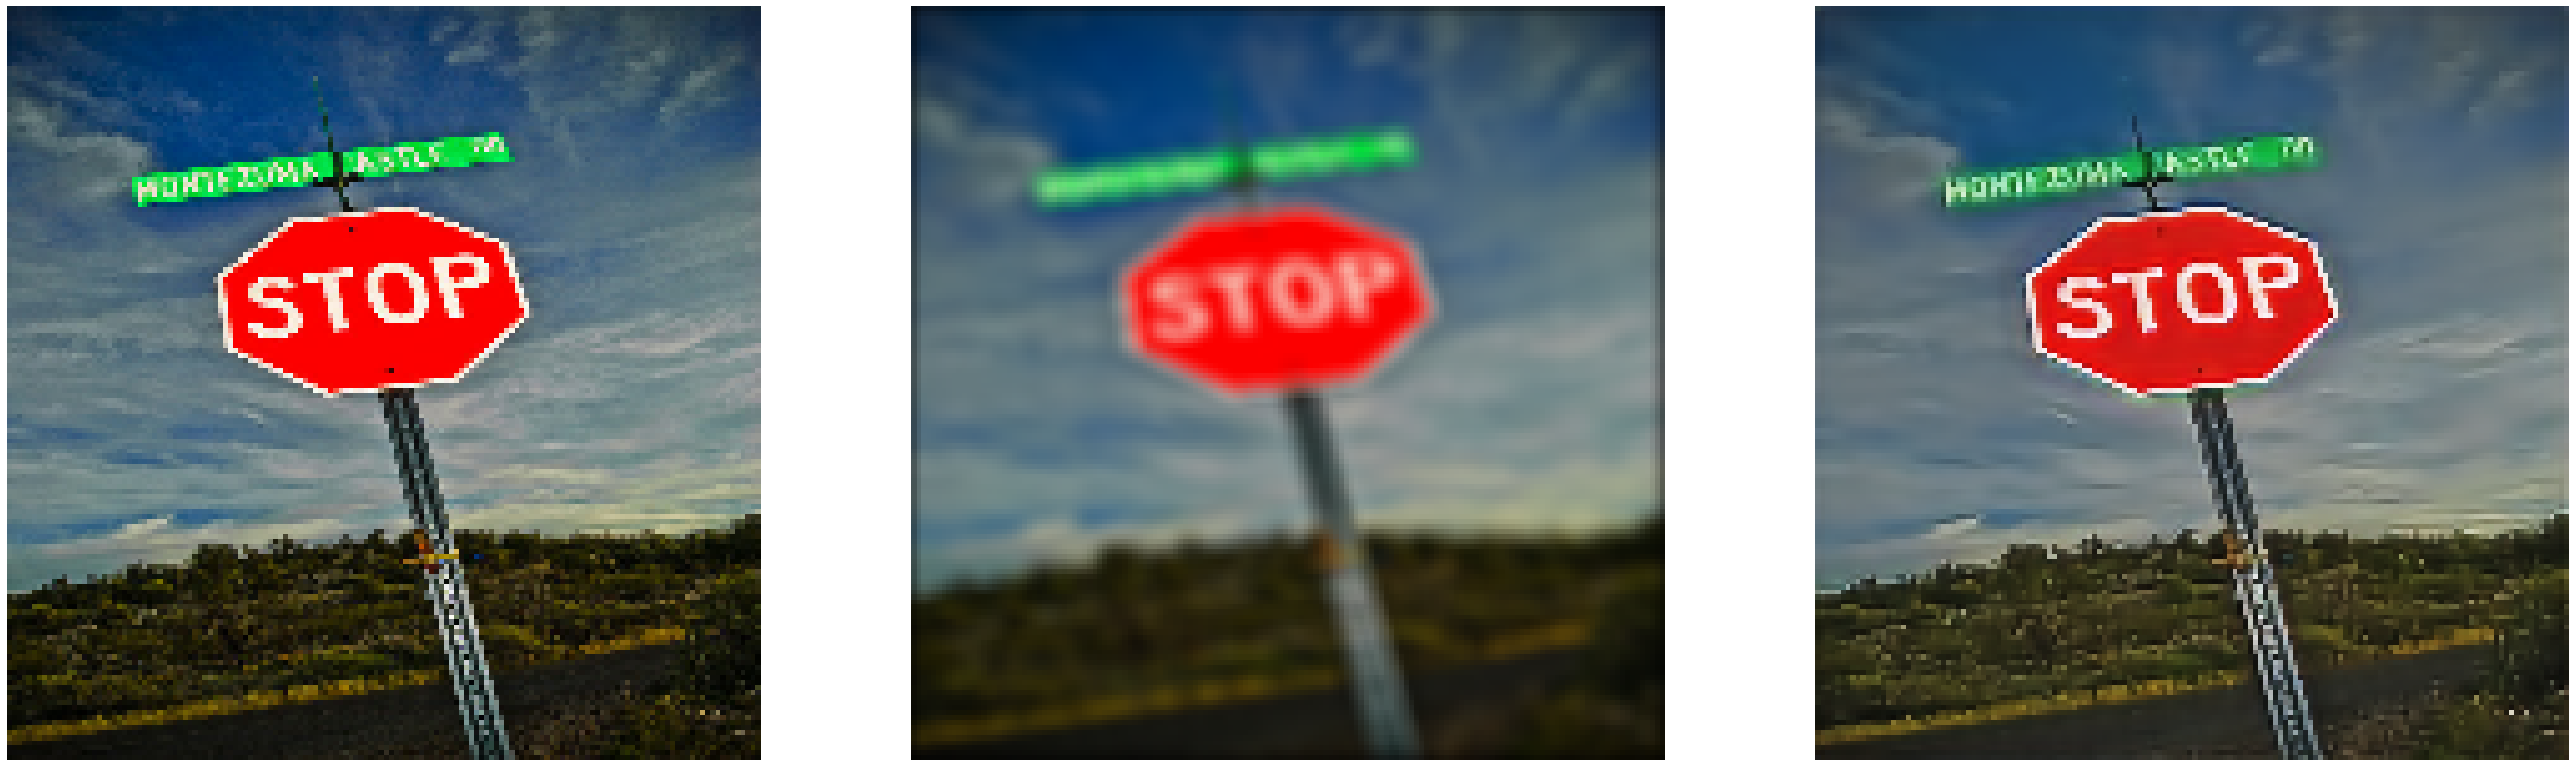
Flou + Bruit: 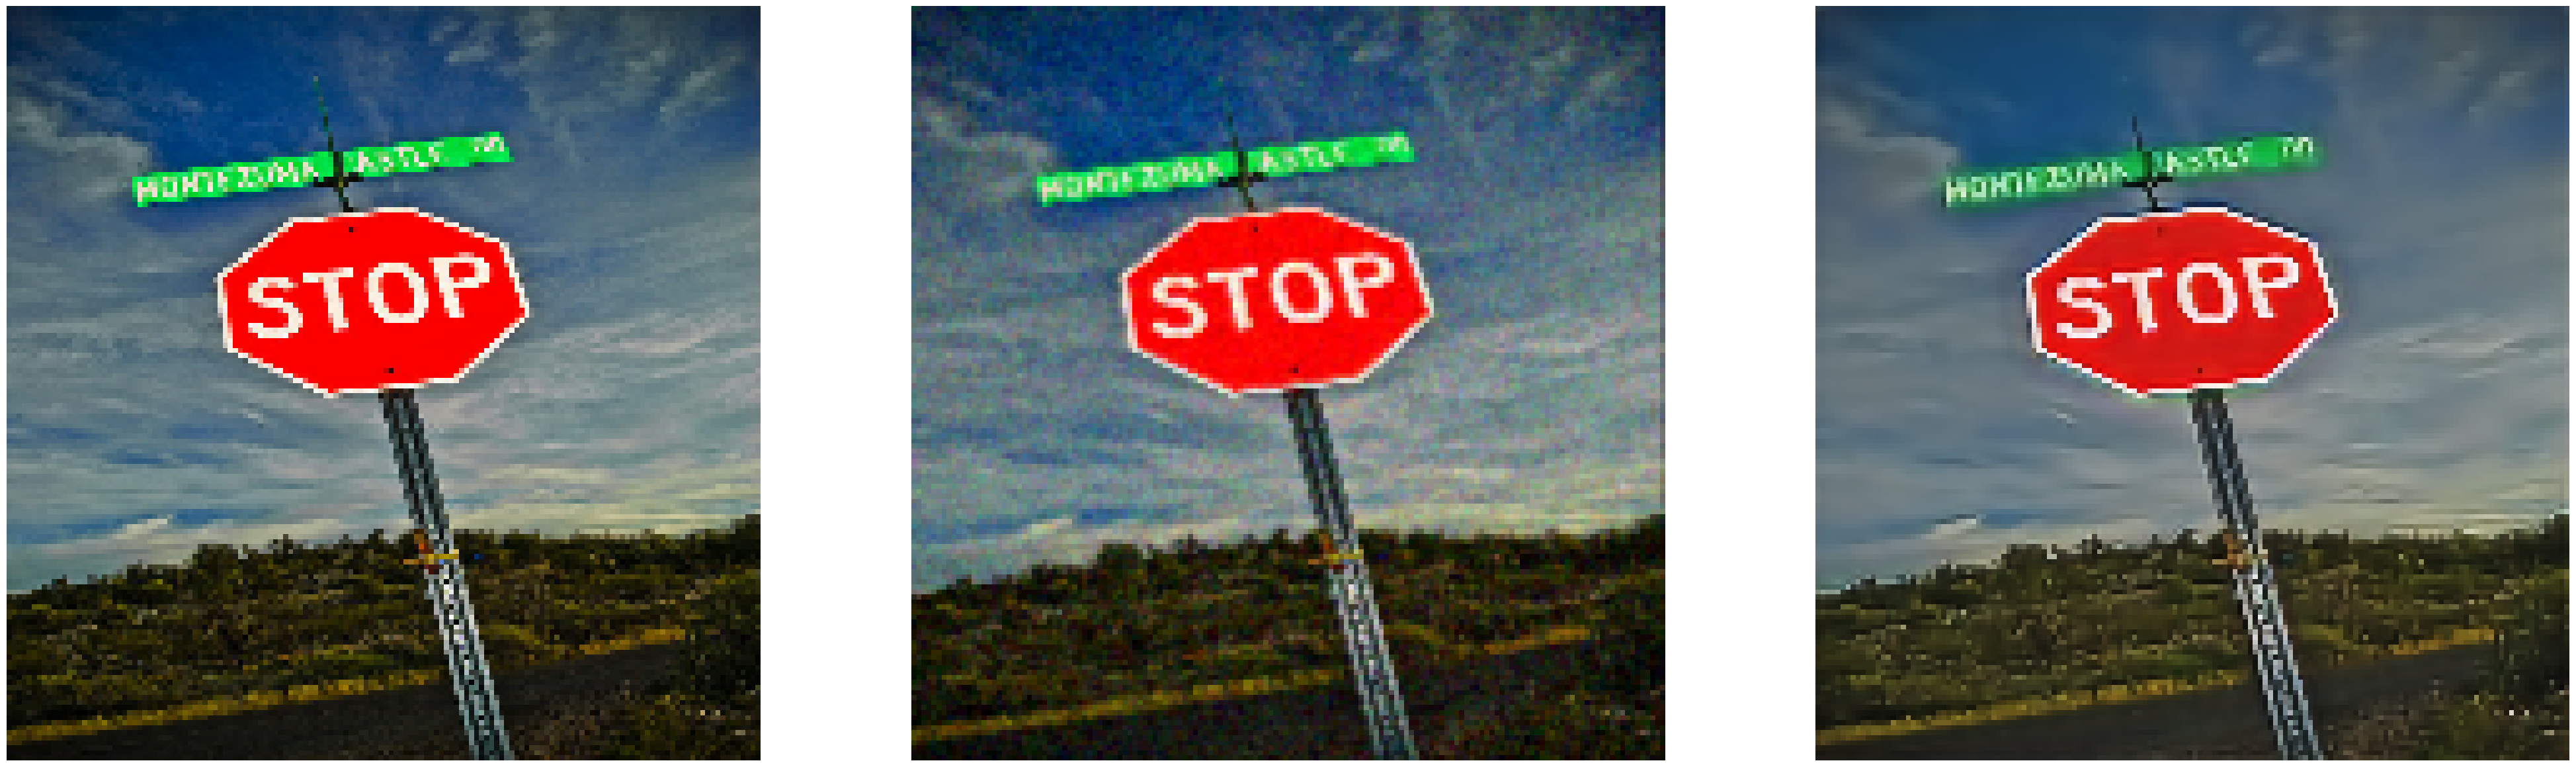 
Image déjà débruitée: 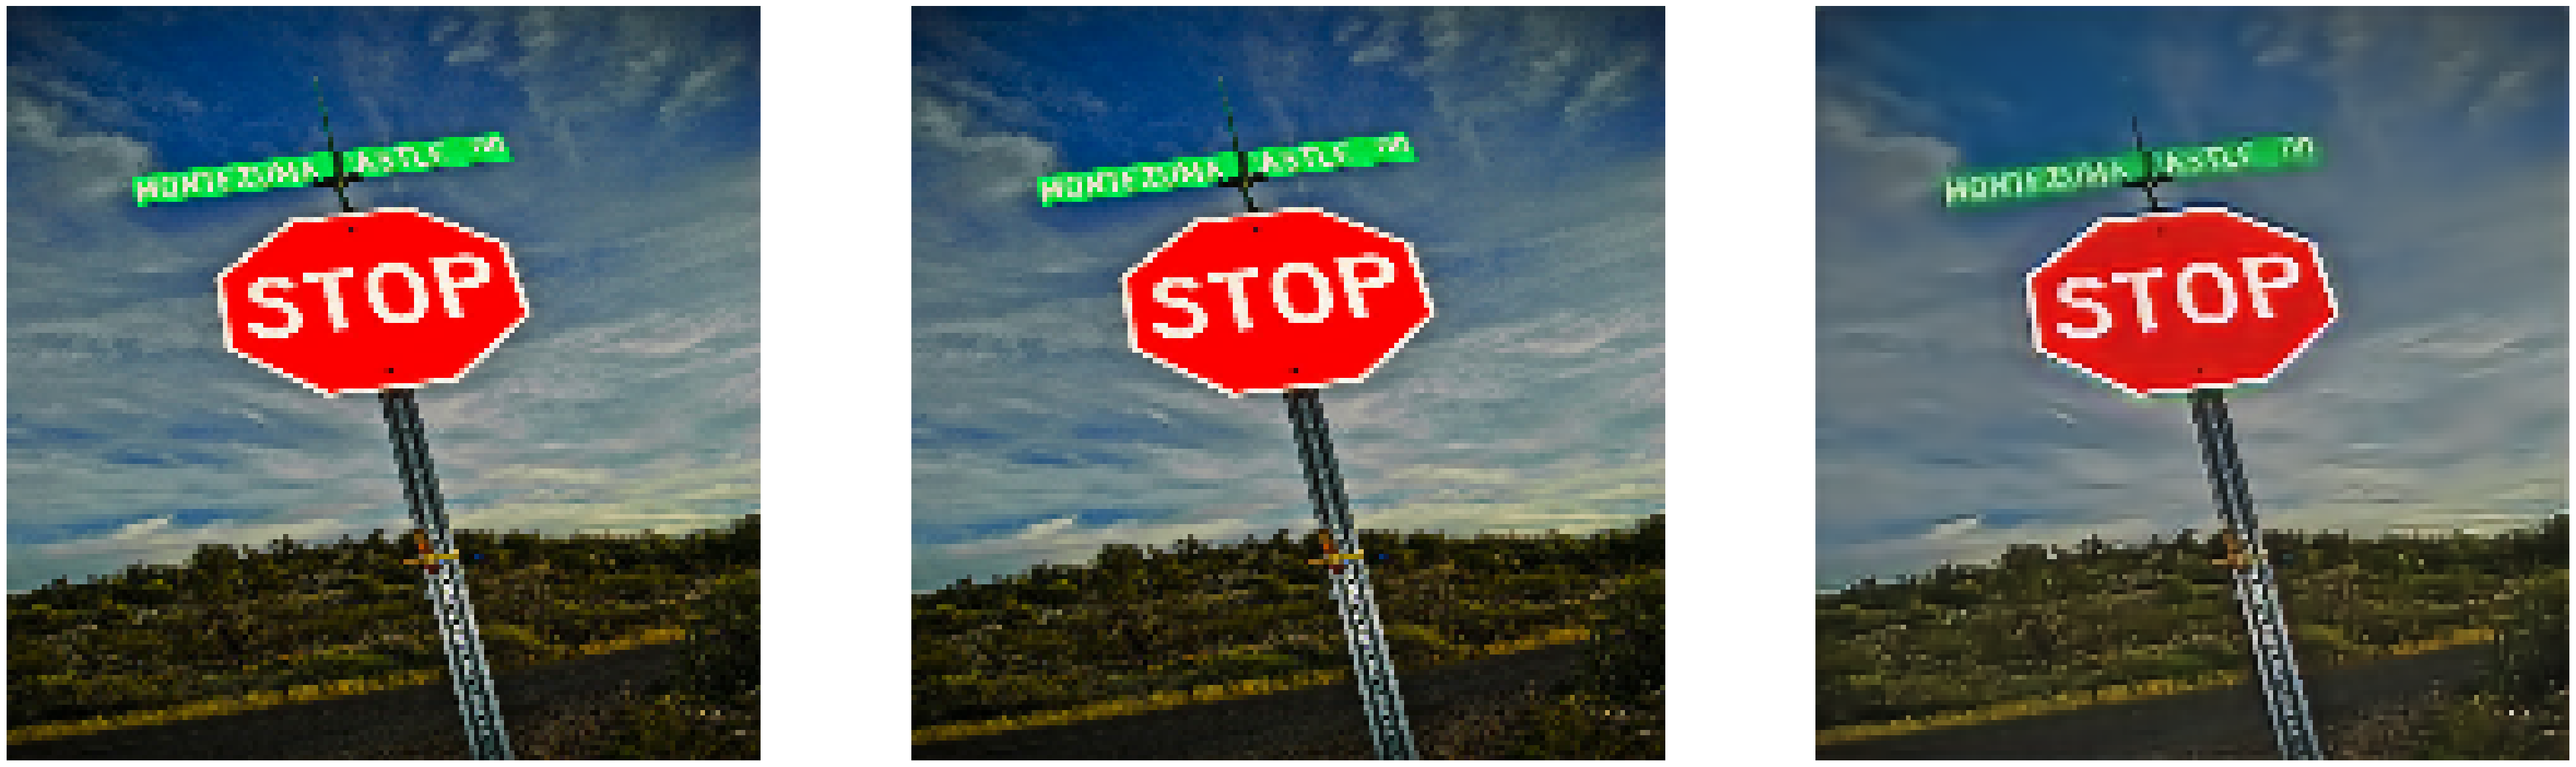

Métrique par perturbation:

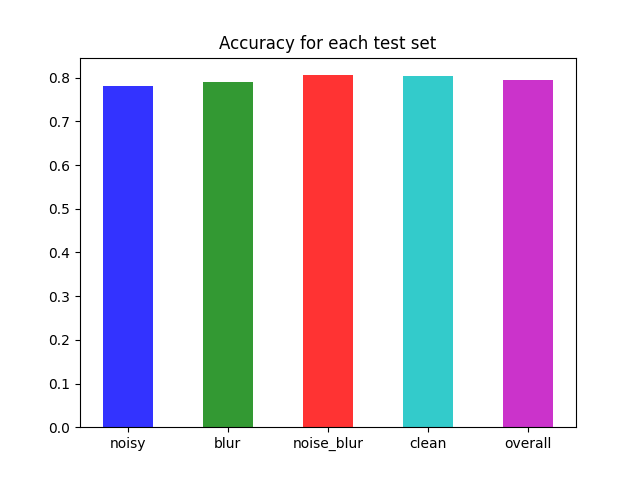

#### Autoencoder convolutif sans réduction de dimension

Ce modèle est très proche du 1er sauf que celui-ci ne réduit pas les dimensions lors de l'encodage. Ceci permet de limiter au mieux la perte d'information durant cette étape.

Image bruitée / Image débruitée :
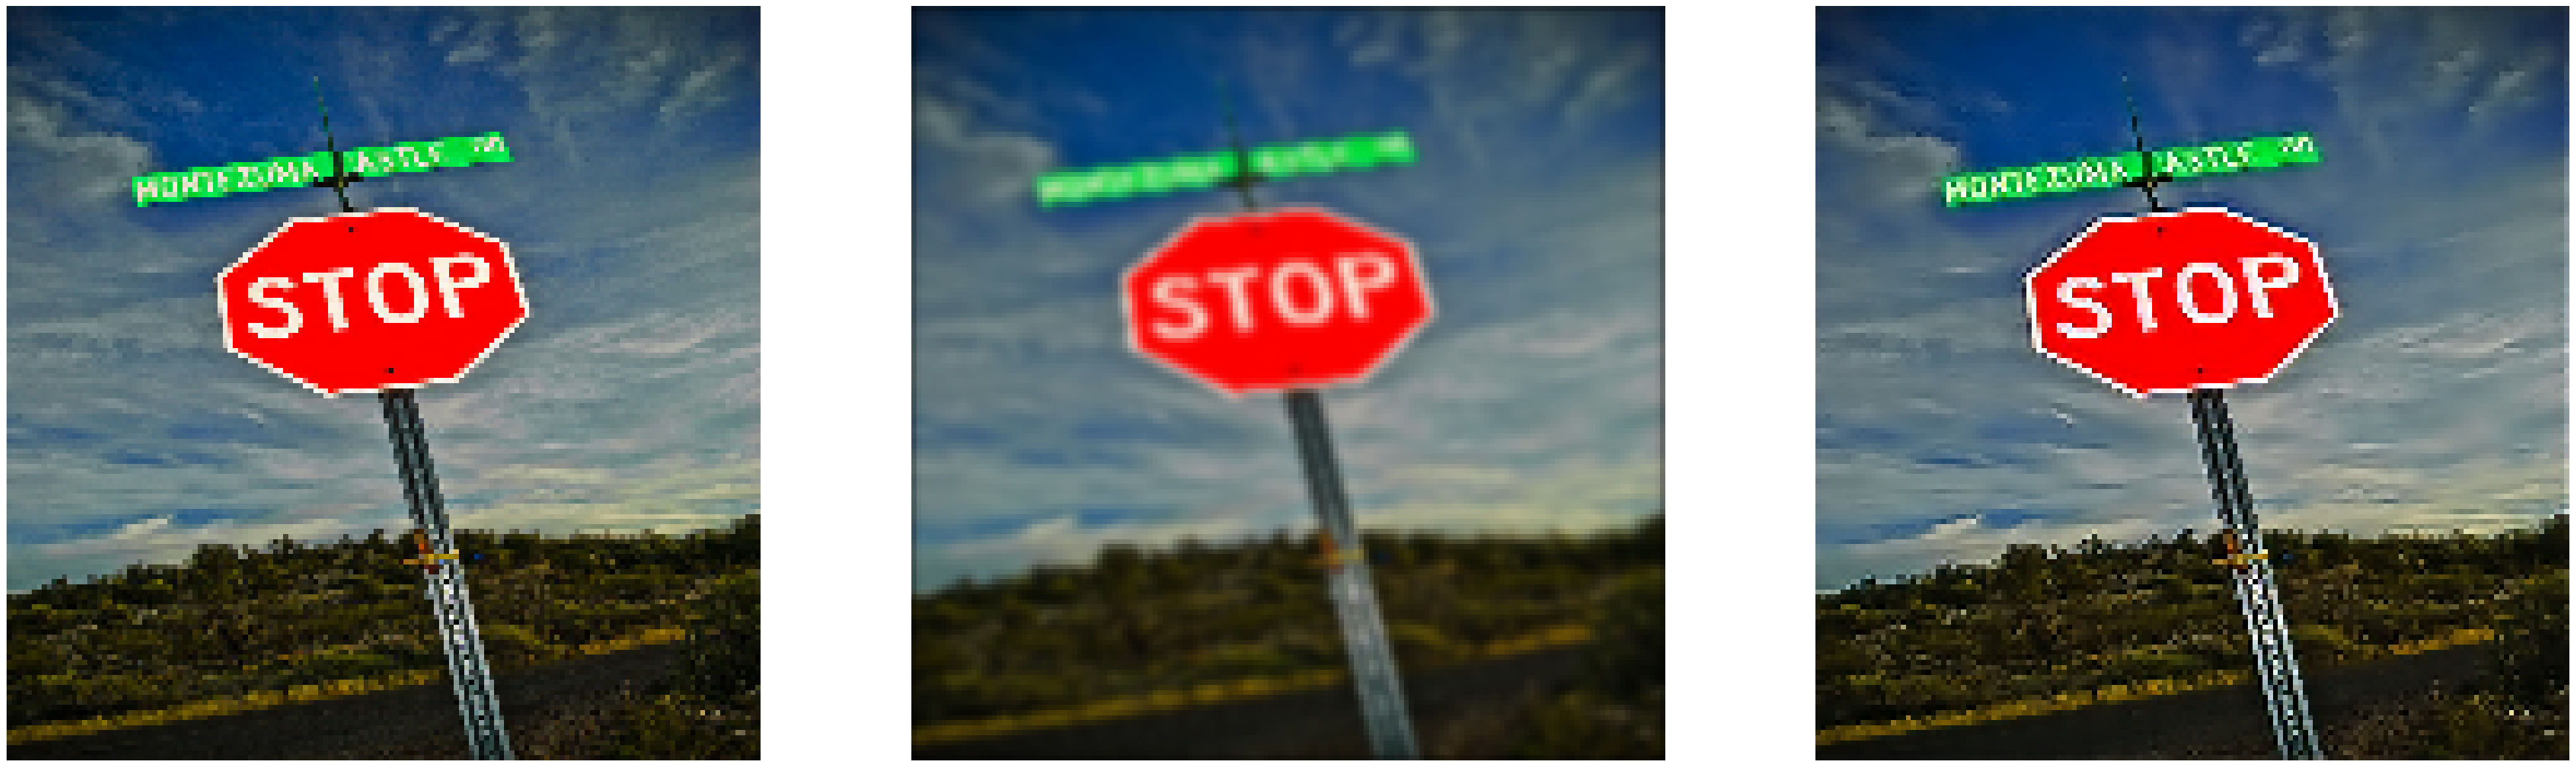
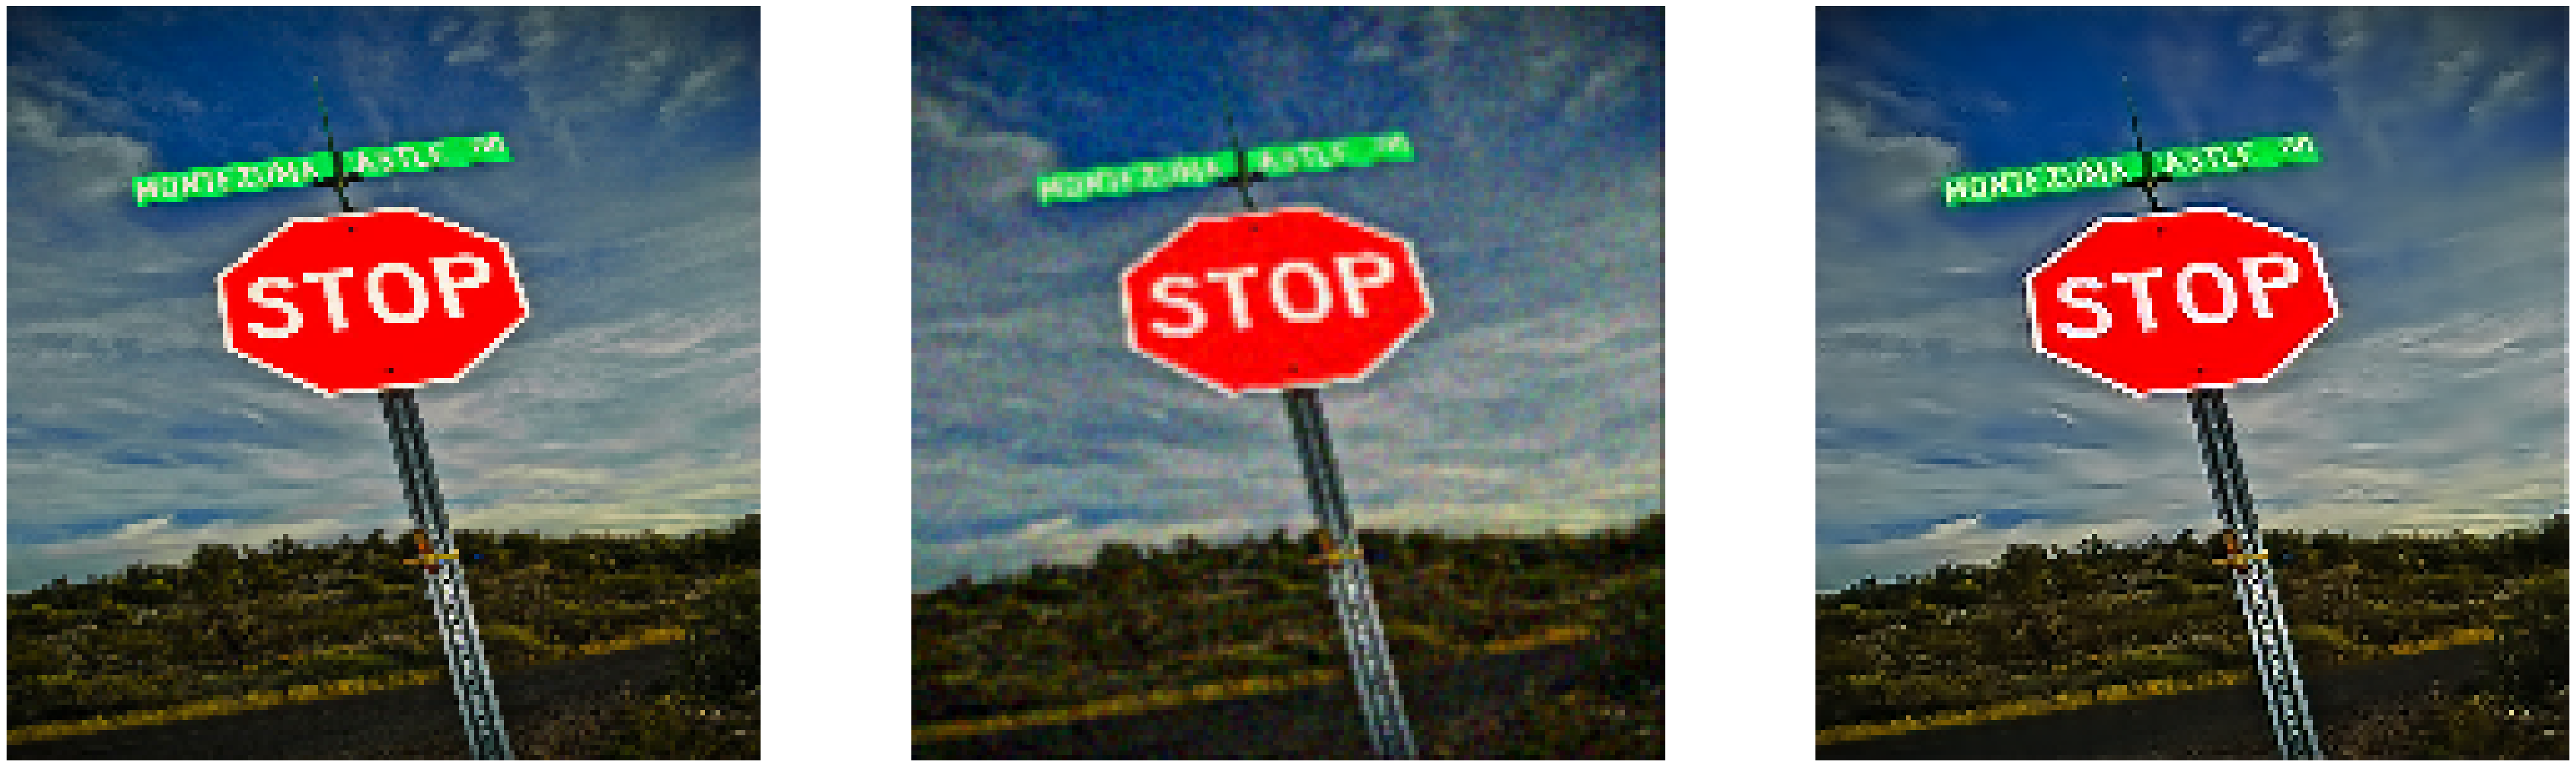
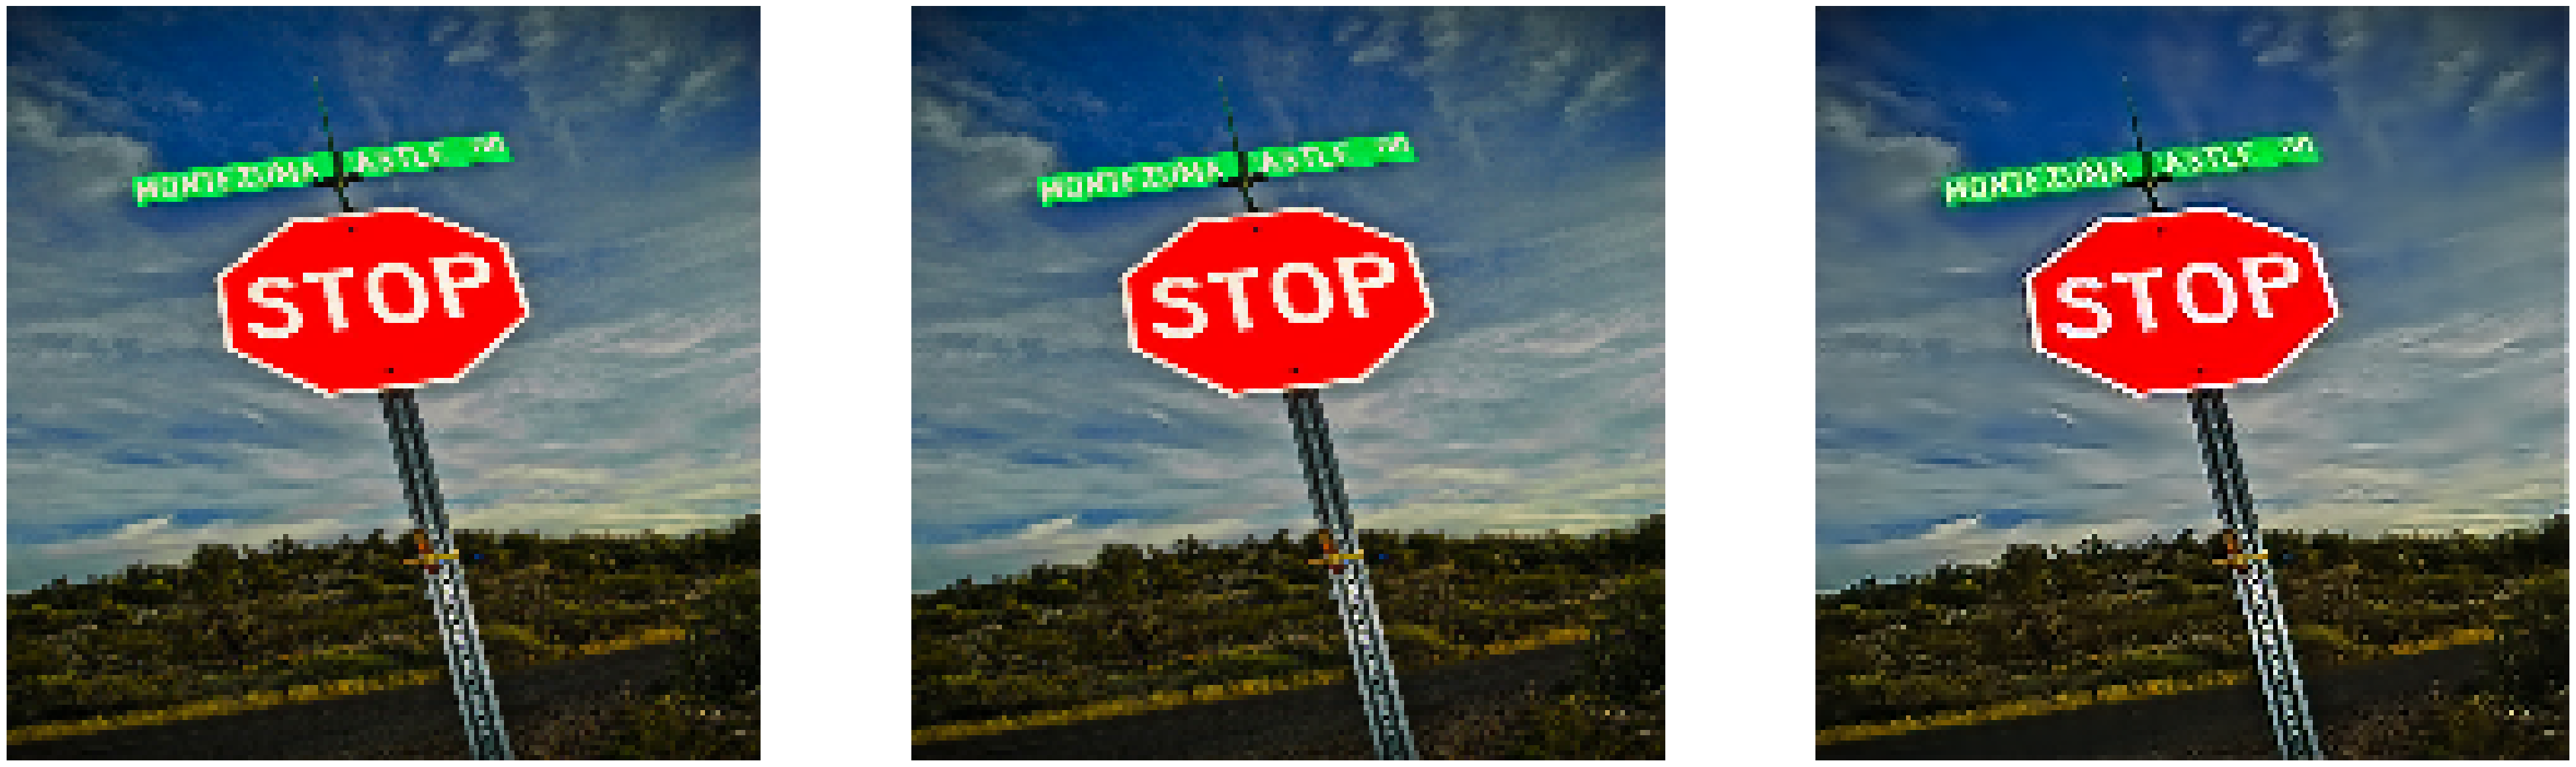

Métrique par perturbation:
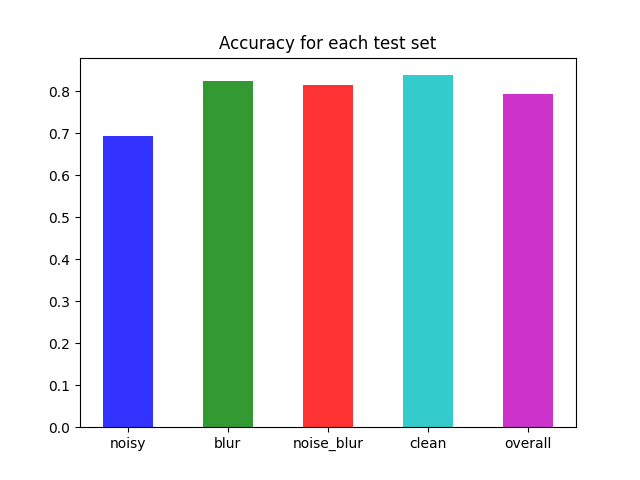

#### Modèle internet V2

Nous avons ensuite pris un modèle que nous avons trouvé sur : https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/ nous avons donc exécuté la pipeline et voici les résultas obtenus avec un bruitage de 35 et un floutage de 1.5 :

Image bruitée / Image débruitée :

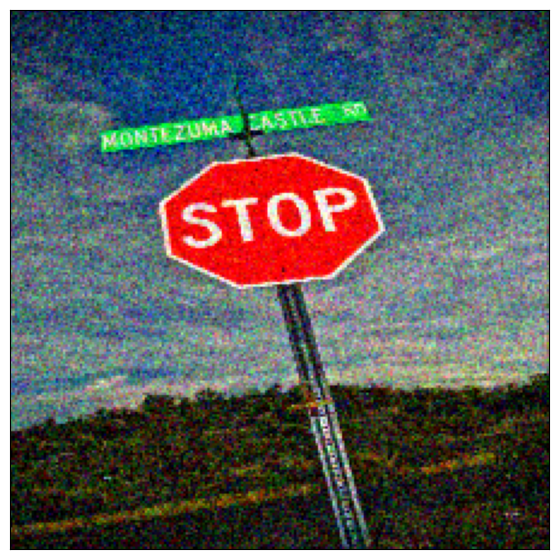  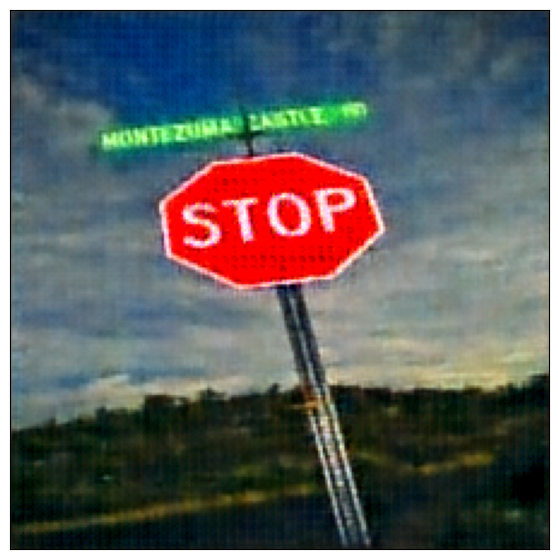

Image bruitée / Image débruitée :

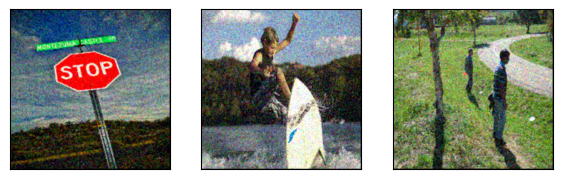

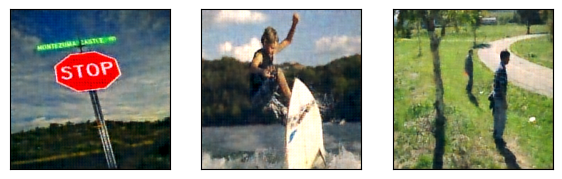

#### Modèle Resnet-decoder

Pour ce modèle, nous avons pris un modèle populaire pré entrainé afin d'encoder nos images
Image bruitée / Image débruitée :

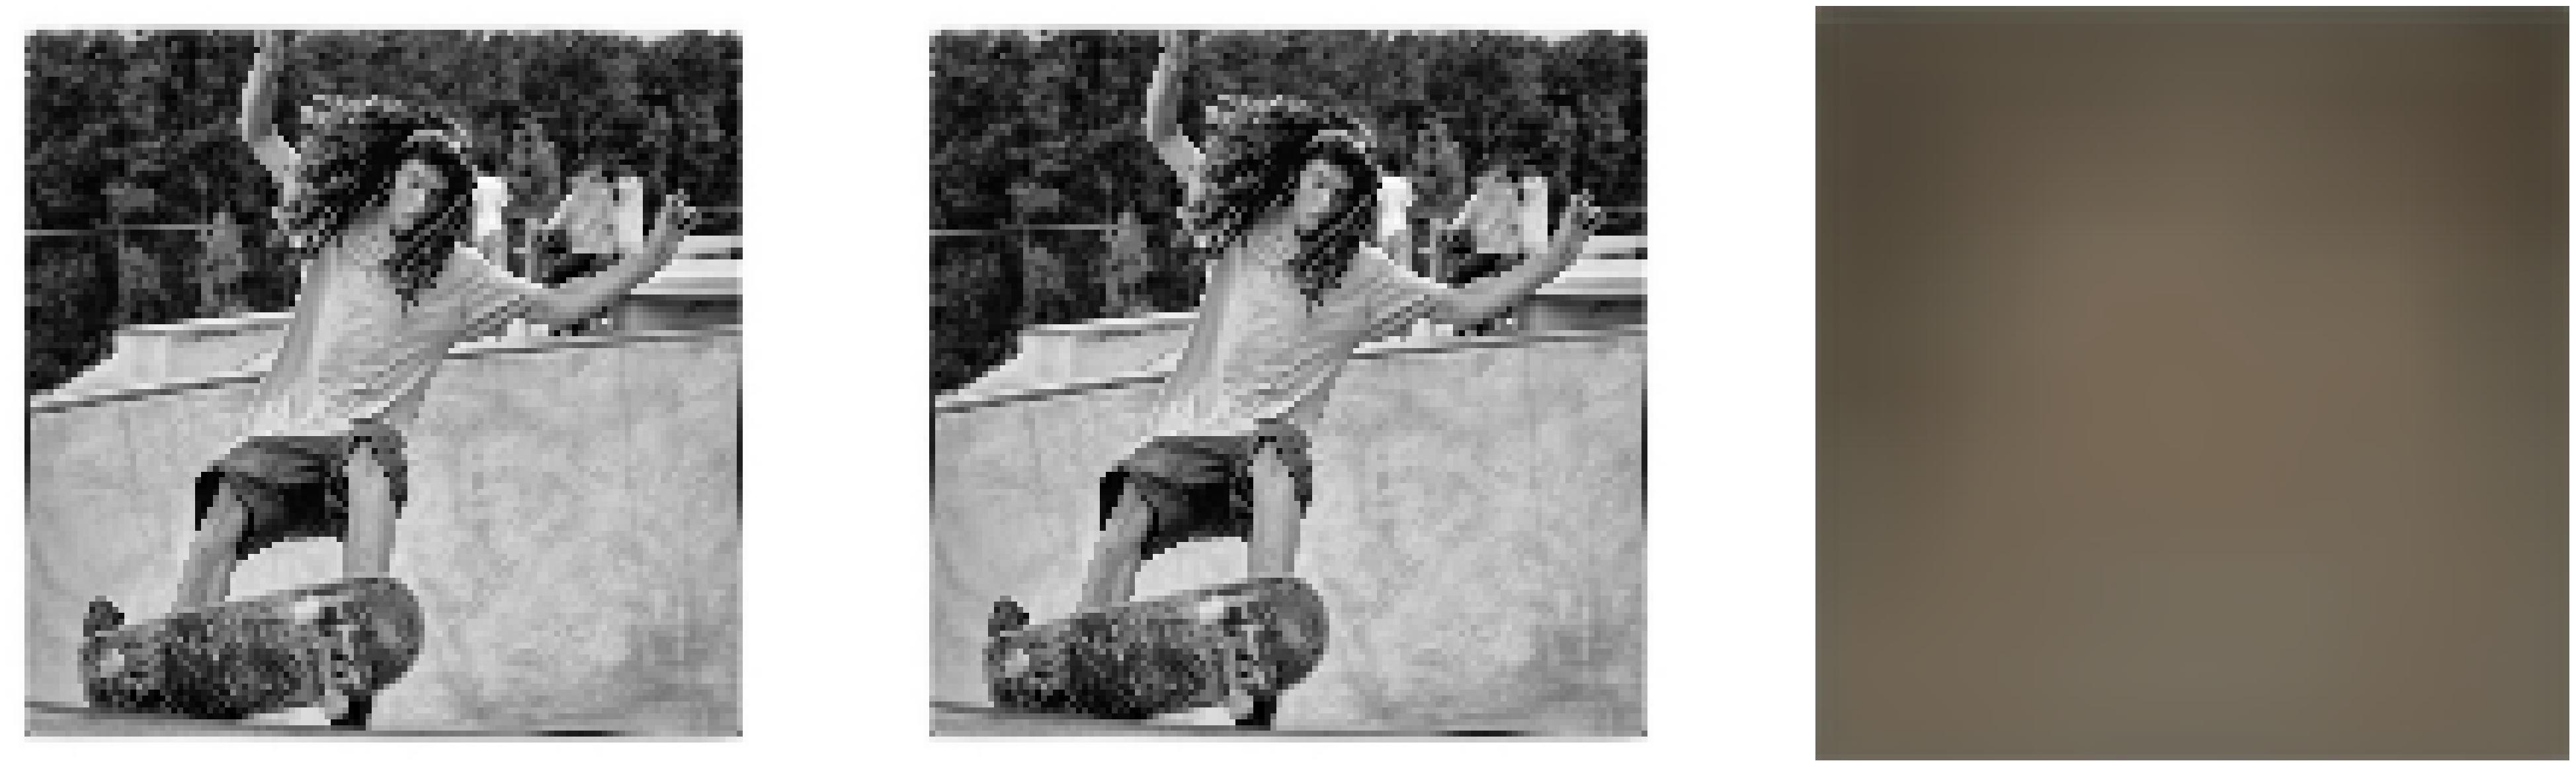

### Comparaison

Afin de choisir un très bon modèle nous allons comparer ceux que l'on a séléctionné grâce à leur accuracy et à leur loss, on pourra ensuite visualiser nos différents résultats à l'aide d'un graphique.

Mais avant ça, on peut voir que le modèle "internet" à de très bon résultats visuellement parlant comparés aux autres modèles. Ce modèle est très bon dans le "dé-floutage" et le débruitage.

Voici donc un graphique représentant les résultats obetnus en ayant fait tourner chaque modèles à 5 epochs, en premier lieu sur la loss fonction : 

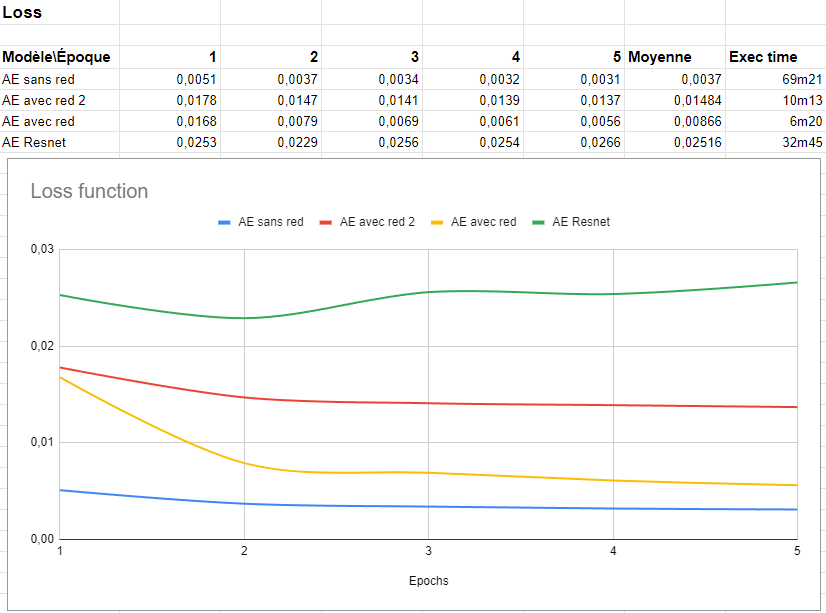

Et ensuite sur l'accuracy du modèle : 

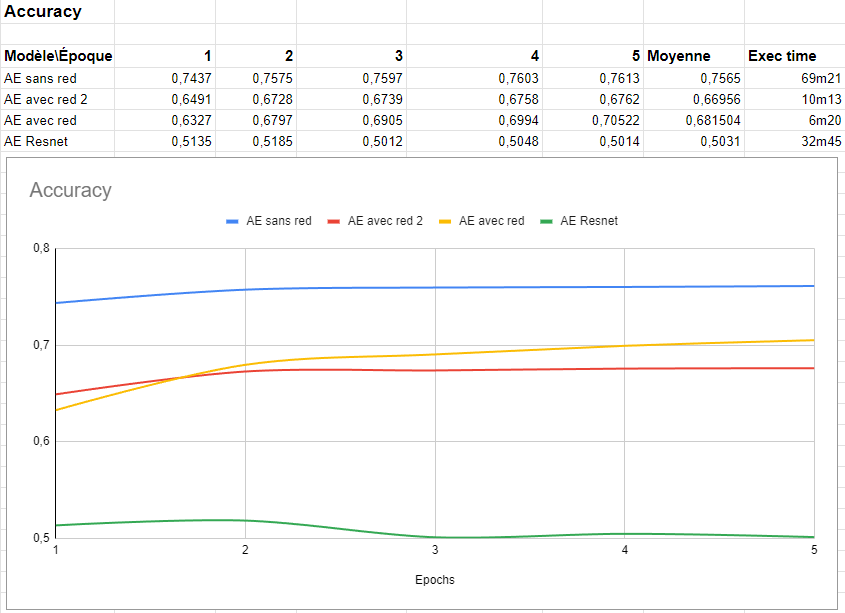

Et on peut généraliser avec la moyennes des valeurs, voici donc les résultats :
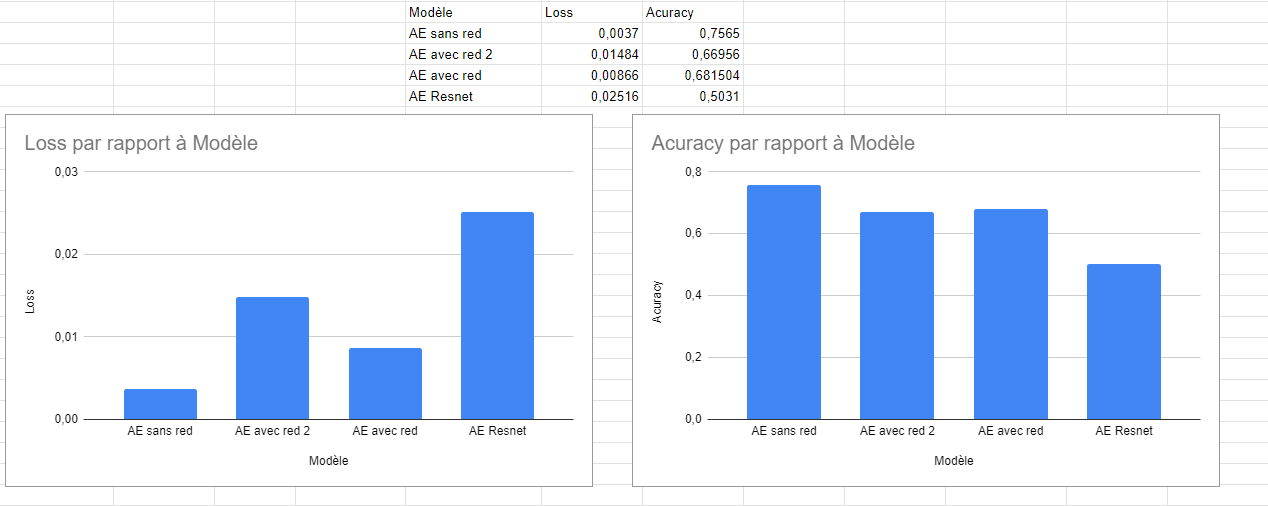

On peut donc appercevoir que le modèle sans réduction de dimension se dégage par rapport aux autres modèles tant par son accuracy que sa loss.

## Conclusion

Pour conclure, après avoir recherché, testé et enfin comparé les modèles pouvant correspondre à notre problème de denoising d'images, nous avons pu analyser les résultats dans le texte précédent.  

Cette étape de denoising et de défloutage nous permettra d'améliorer significativement les résultats futurs d'étiquetage, en effet sans cette étape de nettoyage le modèle obtiendrait de moins bons résultats pour l'étiquetage final.  

En contrepartie on perd évidemment une partie de l'information et de la précision sur la totalité de nos données mais c'est peu impactant sur le résultat final.  

Le meilleur modèle est donc celui qui ne réduit pas la taille de ses informations durant l'encodage pour minimiser la perte de données. Ce modèle démontre une grande polyvalence, car on peut le voir sur les images d'exemple, il ne détériore que très peu les images non bruitées. Chose qu'il est le seul à faire.

Une fois sélectionné, nous avons entrainer ce modèle sur des images plus grandes, ce qui nous a permis d'économiser énormément de temps.